In [1]:
import yfinance as yf 
import sys
from pathlib import Path
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightning as L
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import torch
import joblib
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/workspaces/stock_predictor_lstm_model/venv/lib/python3.12/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
            ~~~~~~~~~~~~~~~~~^^^^^^^^^^^
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/workspaces/stock_predictor_lstm_model/venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/workspaces/stock_predictor_lstm_model/venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 340, in dispatch_control
    async with self._control_lock:
               ^^^^^^^^^^^^^^^^^^
  File "/workspaces/stock_predictor_lstm_model/venv/lib/python3.12/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
       

In [2]:
import torch.nn as nn


class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


model = StockLSTM()


In [3]:
def load_stock_data(ticker, start, end):
    # Ensure Yahoo Finance-compatible ticker (e.g., Brazilian stocks use .SA)
    yf_ticker = ticker if "." in ticker else f"{ticker}.SA"
    try:
        df = yf.download(yf_ticker, start=start, end=end, auto_adjust=False)[["Close"]]
    except Exception as e:
        raise RuntimeError(f"Failed to download data for {yf_ticker}: {e}")
    if df is None or df.empty:
        raise RuntimeError(f"No data returned for {yf_ticker}. Check the symbol and date range.")
    df.dropna(inplace=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    return df

In [4]:
def scale_data(df):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df.values)
    return scaled, scaler

In [5]:
def create_sequences(data, seq_length=50):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [6]:


def load_data( stock = "ABEV3",start: str = "2015-01-01", end: str = "2026-01-01"):
    # 1. Load stock data
    df = load_stock_data(stock, start=start, end=end)
    df.reset_index(inplace=True)

    # 2. Scale the "Close" data
    scaled_data, scaler = scale_data(df[["Close"]])
    df["ScaledClose"] = scaled_data

    # 3. Create input sequences for the model
    X_np, y_np = create_sequences(scaled_data, seq_length=50)

    # Train/test split (e.g., last 20% for test)
    split_idx = int(len(X_np) * 0.8)
    X_train, y_train = X_np[:split_idx], y_np[:split_idx]
    X_test, y_test = X_np[split_idx:], y_np[split_idx:]

    # 4. Convert to PyTorch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32)

    # 5. Setup DataLoader
    dataset = TensorDataset(X_train_t, y_train_t)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 6. Define model, loss, optimizer
    model = StockLSTM(input_size=1, hidden_size=64, num_layers=2)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 7. Train the model
    loss_history = []
    model.train()
    for epoch in range(100):
        epoch_loss = 0.0
        for X_batch, y_batch in loader:
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(loader)
        loss_history.append(avg_loss)

    # 8. Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_t).numpy()
        y_true_test = y_test_t.numpy()

    # Inverse transform predictions and truths
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)
    y_true_test_inv = scaler.inverse_transform(y_true_test)

    # Metrics
    mse = float(np.mean((y_true_test - y_pred_test) ** 2))
    mae = float(np.mean(np.abs(y_true_test - y_pred_test)))
    rmse = float(np.sqrt(mse))
    mape = float(np.mean(np.abs((y_true_test - y_pred_test) / np.clip(y_true_test, 1e-8, None))) * 100)
    # R2 on scaled values
    ss_res = np.sum((y_true_test - y_pred_test) ** 2)
    ss_tot = np.sum((y_true_test - np.mean(y_true_test)) ** 2)
    r2 = float(1 - ss_res / ss_tot) if ss_tot > 0 else float("nan")

    # 9. Predict the next price using last sequence
    with torch.no_grad():
        last_seq = torch.tensor(scaled_data[-50:], dtype=torch.float32).unsqueeze(0)
        predicted_next_scaled = model(last_seq).numpy()
        predicted_next_price = scaler.inverse_transform(predicted_next_scaled)[0][0]

    return {
        "loss_history": [float(l) for l in loss_history],
        "predicted_next_price": float(predicted_next_price),
        "y_true_scaled": y_true_test.squeeze().tolist(),
        "y_pred_scaled": y_pred_test.squeeze().tolist(),
        "y_true": y_true_test_inv.squeeze().tolist(),
        "y_pred": y_pred_test_inv.squeeze().tolist(),
        "metrics": {
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE_%": mape,
            "R2": r2
        },
        "model": model,
        "scaler": scaler
    }

In [7]:
results = load_data(stock="ABEV3.SA", start="2020-01-01", end="2024-12-31")
print("Training completed!")
print("Metrics:")
for k, v in results["metrics"].items():
    print(f"  {k}: {v:.6f}")
print(f"Predicted next price: R$ {results['predicted_next_price']:.2f}")

[*********************100%***********************]  1 of 1 completed


Training completed!
Metrics:
  MSE: 0.000641
  MAE: 0.019232
  RMSE: 0.025320
  MAPE_%: 19.164825
  R2: 0.890518
Predicted next price: R$ 12.03


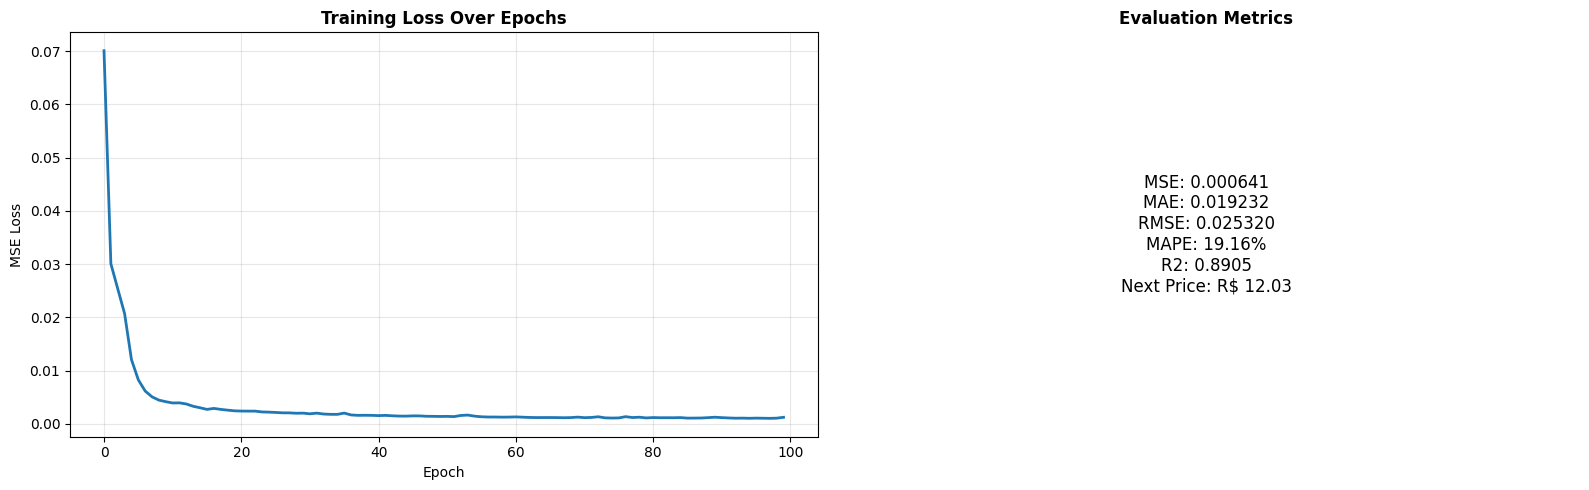

In [8]:
# Plot training loss
fig, ax = plt.subplots(1,2,figsize=(16, 5))
ax[0].plot(results['loss_history'], linewidth=2)
ax[0].set_title('Training Loss Over Epochs', fontsize=12, fontweight='bold')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE Loss')
ax[0].grid(True, alpha=0.3)

# Metrics summary text
m = results['metrics']
metrics_text = (f"MSE: {m['MSE']:.6f}\n"
                f"MAE: {m['MAE']:.6f}\n"
                f"RMSE: {m['RMSE']:.6f}\n"
                f"MAPE: {m['MAPE_%']:.2f}%\n"
                f"R2: {m['R2']:.4f}\n"
                f"Next Price: R$ {results['predicted_next_price']:.2f}")
ax[1].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12)
ax[1].set_title('Evaluation Metrics', fontsize=12, fontweight='bold')
ax[1].axis('off')

plt.tight_layout()
plt.show()

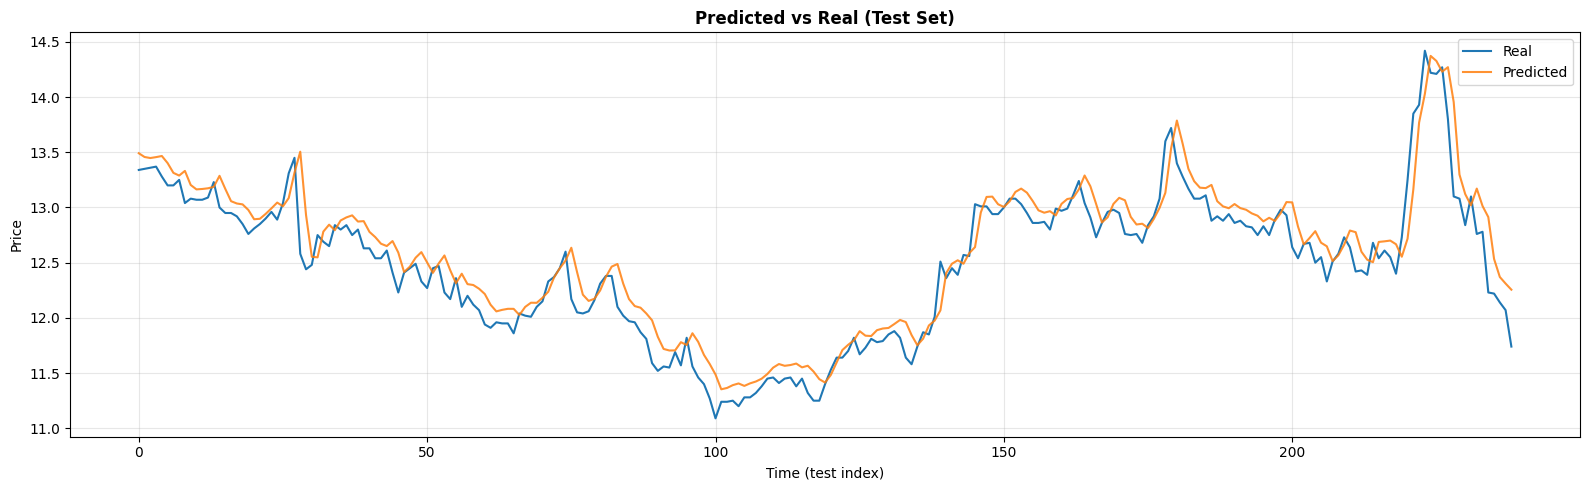

In [9]:
fig, axes = plt.subplots( figsize=(16, 5))

axes.plot(results['y_true'], label='Real', color='tab:blue')
axes.plot(results['y_pred'], label='Predicted', color='tab:orange', alpha=0.85)
axes.set_title('Predicted vs Real (Test Set)', fontsize=12, fontweight='bold')
axes.set_xlabel('Time (test index)')
axes.set_ylabel('Price')
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

In [10]:
import os, joblib
torch.save(results["model"].state_dict(), "/workspaces/stock_predictor_lstm_model/models/stock_lstm.pt")
joblib.dump(results["scaler"], "/workspaces/stock_predictor_lstm_model/models/scaler.joblib")
print("Saved models:", "/workspaces/stock_predictor_lstm_model/models/stock_lstm.pt", "/workspaces/stock_predictor_lstm_model/models/scaler.joblib")

Saved models: /workspaces/stock_predictor_lstm_model/models/stock_lstm.pt /workspaces/stock_predictor_lstm_model/models/scaler.joblib


In [20]:
# Load saved artifacts
loaded_model = StockLSTM(input_size=1, hidden_size=64, num_layers=2)
loaded_model.load_state_dict(torch.load("/workspaces/stock_predictor_lstm_model/models/stock_lstm.pt"))
loaded_model.eval()
loaded_scaler = joblib.load("/workspaces/stock_predictor_lstm_model/models/scaler.joblib")

ticker = "AXIA6.SA"
df_retrained = yf.download(ticker, start="2025-01-01")
closes_retrained = df_retrained["Close"].dropna().values.reshape(-1, 1)

# Scale data
scaled_retrained = loaded_scaler.transform(closes_retrained)

seq_length = min(50, len(scaled_retrained))

if seq_length == 0:
    print(f"⚠ Error: No data available for {ticker}")
else:
    # Take last available points and predict next
    seq = torch.tensor(scaled_retrained[-seq_length:], dtype=torch.float32).unsqueeze(0)
    
    # Pad with zeros if less than 50
    if seq_length < 50:
        padding = torch.zeros((1, 50 - seq_length, 1), dtype=torch.float32)
        seq = torch.cat([padding, seq], dim=1)
    
    with torch.no_grad():
        pred_scaled = loaded_model(seq).numpy()
        pred_price = loaded_scaler.inverse_transform(pred_scaled)[0][0]
    
    print(f"Last known close ({ticker}): R$ {closes_retrained[-1][0]:.2f}")
    print(f"Predicted next close ({ticker}): R$ {pred_price:.2f}")
    print(f"Predicted change: R$ {pred_price - closes_retrained[-1][0]:.2f}")
    print(f"Using {seq_length} days of data (model trained on 50)")
    print("=" * 60)

/tmp/ipykernel_4641/1495897515.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_retrained = yf.download(ticker, start="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Last known close (AXIA6.SA): R$ 52.52
Predicted next close (AXIA6.SA): R$ 39.73
Predicted change: R$ -12.79
Using 50 days of data (model trained on 50)


In [21]:
X_2025, y_2025 = create_sequences(scaled_retrained, seq_length=50)

if len(X_2025) > 0:
    X_2025_t = torch.tensor(X_2025, dtype=torch.float32)
    y_2025_t = torch.tensor(y_2025, dtype=torch.float32)
    
    # Predict on all sequences
    loaded_model.eval()
    with torch.no_grad():
        y_2025_pred = loaded_model(X_2025_t).numpy()
    
    # Inverse transform for real prices
    y_2025_true_inv = loaded_scaler.inverse_transform(y_2025)
    y_2025_pred_inv = loaded_scaler.inverse_transform(y_2025_pred)
    
    # Calculate metrics for 2025 test data
    mse_2025 = float(np.mean((y_2025 - y_2025_pred) ** 2))
    mae_2025 = float(np.mean(np.abs(y_2025 - y_2025_pred)))
    rmse_2025 = float(np.sqrt(mse_2025))
    mape_2025 = float(np.mean(np.abs((y_2025 - y_2025_pred) / np.clip(y_2025, 1e-8, None))) * 100)
    ss_res_2025 = np.sum((y_2025 - y_2025_pred) ** 2)
    ss_tot_2025 = np.sum((y_2025 - np.mean(y_2025)) ** 2)
    r2_2025 = float(1 - ss_res_2025 / ss_tot_2025) if ss_tot_2025 > 0 else float("nan")
    
    # Store in results dict for plotting
    results_2025 = {
        "y_true": y_2025_true_inv.squeeze().tolist(),
        "y_pred": y_2025_pred_inv.squeeze().tolist(),
        "metrics": {
            "MSE": mse_2025,
            "MAE": mae_2025,
            "RMSE": rmse_2025,
            "MAPE_%": mape_2025,
            "R2": r2_2025
        },
        "predicted_next_price": pred_price
    }
    
    print(f"✓ Generated {len(X_2025)} predictions for {ticker} 2025 data")
    print(f"Test Set Metrics (2025):")
    for k, v in results_2025["metrics"].items():
        print(f"  {k}: {v:.6f}")
else:
    print("Not enough data for sequence generation")

✓ Generated 195 predictions for AXIA6.SA 2025 data
Test Set Metrics (2025):
  MSE: 0.546768
  MAE: 0.602583
  RMSE: 0.739438
  MAPE_%: 17.080517
  R2: 0.194854


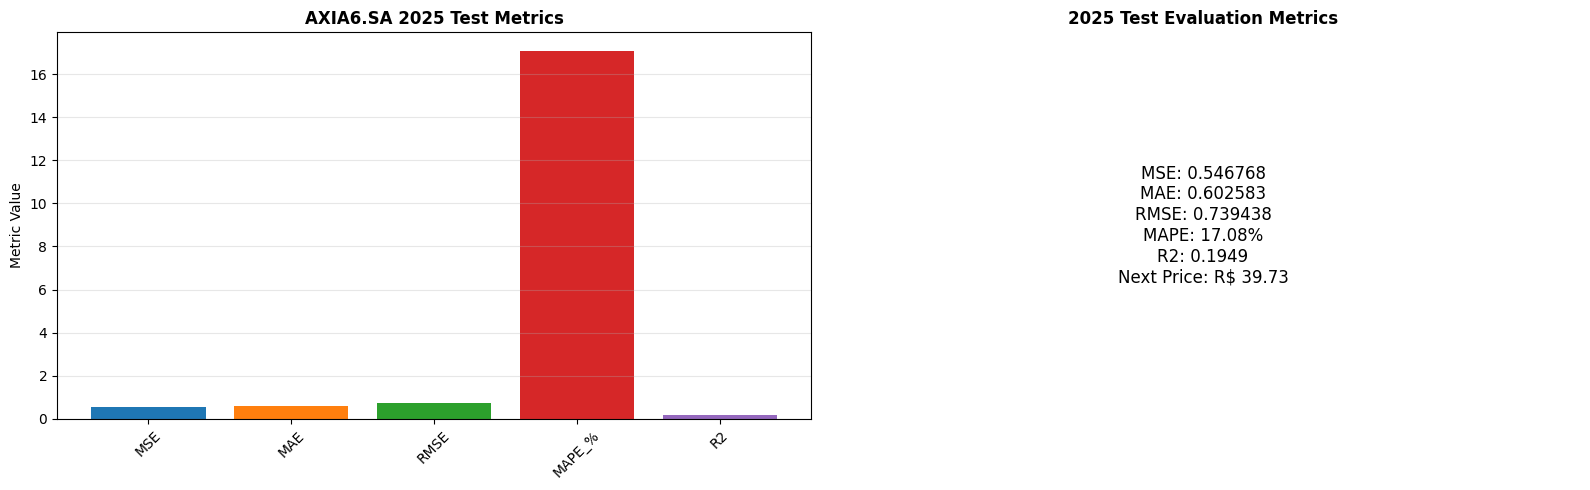

In [22]:
# Plot metrics for 2025 test data (similar to cell 18)
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Left: Since we don't have training history for loaded model, show a comparison bar chart
metrics_names = ['MSE', 'MAE', 'RMSE', 'MAPE_%', 'R2']
metrics_vals = [results_2025['metrics'][m] for m in metrics_names]
ax[0].bar(range(len(metrics_names)), metrics_vals, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])
ax[0].set_xticks(range(len(metrics_names)))
ax[0].set_xticklabels(metrics_names, rotation=45)
ax[0].set_title(f'{ticker} 2025 Test Metrics', fontsize=12, fontweight='bold')
ax[0].set_ylabel('Metric Value')
ax[0].grid(True, alpha=0.3, axis='y')

# Right: Metrics summary text
m = results_2025['metrics']
metrics_text = (f"MSE: {m['MSE']:.6f}\n"
                f"MAE: {m['MAE']:.6f}\n"
                f"RMSE: {m['RMSE']:.6f}\n"
                f"MAPE: {m['MAPE_%']:.2f}%\n"
                f"R2: {m['R2']:.4f}\n"
                f"Next Price: R$ {results_2025['predicted_next_price']:.2f}")
ax[1].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12)
ax[1].set_title('2025 Test Evaluation Metrics', fontsize=12, fontweight='bold')
ax[1].axis('off')

plt.tight_layout()
plt.show()

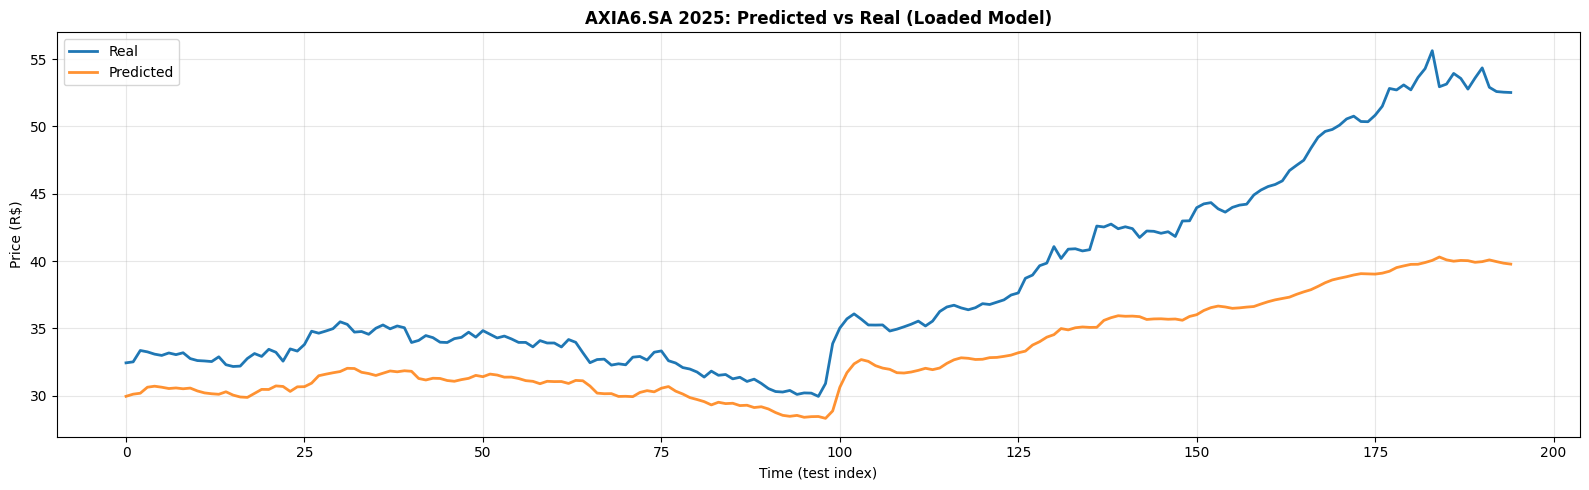

In [23]:
fig, axes = plt.subplots(figsize=(16, 5))

axes.plot(results_2025['y_true'], label='Real', color='tab:blue', linewidth=2)
axes.plot(results_2025['y_pred'], label='Predicted', color='tab:orange', alpha=0.85, linewidth=2)
axes.set_title(f'{ticker} 2025: Predicted vs Real (Loaded Model)', fontsize=12, fontweight='bold')
axes.set_xlabel('Time (test index)')
axes.set_ylabel('Price (R$)')
axes.legend()
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()